In [1]:
%%bash
rm -R ./cython_galaxy_extended

In [2]:
import os
os.mkdir('./cython_galaxy_extended')

In [3]:
%%file ./cython_galaxy_extended/abstand.pxd
cdef void Abstand (double [:, :], double[:], int, int) nogil

Writing ./cython_galaxy_extended/abstand.pxd


In [4]:
%%file ./cython_galaxy_extended/abstand.pyx
cimport cython
#Abstands Funktion
#Abstand_Sonne = position[1] - position[0]

@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Abstand (double [:, :] position_view , double[:] result ,int head, int tail) nogil:   
    result[0] = position_view[head][0] - position_view[tail][0]
    result[1] = position_view[head][1] - position_view[tail][1]
    result[2] = position_view[head][2] - position_view[tail][2]

Writing ./cython_galaxy_extended/abstand.pyx


In [5]:
%%file ./cython_galaxy_extended/betrag.pxd
cdef void Betrag (double [:], double[:]) nogil

Writing ./cython_galaxy_extended/betrag.pxd


In [6]:
%%file ./cython_galaxy_extended/betrag.pyx
cimport cython
from libc.math cimport sqrt


#Betrags Funktion
#Betrag_Erde  = sqrt( Abstand_Erde**2 + Abstand_Erde**2 + Abstand_Erde**2)
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Betrag (double [:] abstand_view , double[:] result) nogil:
    result[0] = sqrt(abstand_view[0]**2 + abstand_view[1]**2 + abstand_view[2]**2)

Writing ./cython_galaxy_extended/betrag.pyx


In [7]:
%%file ./cython_galaxy_extended/kraft.pxd
cdef void Kraft (double [:], double [:],  double [:], int, int, double[:]) nogil

Writing ./cython_galaxy_extended/kraft.pxd


In [8]:
%%file ./cython_galaxy_extended/kraft.pyx
cimport cython

#Kraft Funktion
#Kraft_Erde = G * (masse_erde * masse_sonne / (Betrag_Erde  ** 3)) * Abstand_Erde
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Kraft (double [:] masse_view, double [:] abstand_view,  double [:] Betrag, \
                  int head, int tail, double[:] result) nogil:
    
    cdef double g1 = 6.672
    cdef double g2 = 10
    cdef double g3 = -11
    
    cdef double G = g1 * g2 ** g3
    cdef double betrag = Betrag[0] ** 3

    cdef double masse_multyply = masse_view[head] * masse_view[tail]
    
    result[0] = G * (masse_multyply / betrag) * abstand_view[0]
    result[1] = G * (masse_multyply / betrag) * abstand_view[1]
    result[2] = G * (masse_multyply / betrag) * abstand_view[2]

Writing ./cython_galaxy_extended/kraft.pyx


In [9]:
%%file ./cython_galaxy_extended/beschleunigung.pxd
cdef void Beschleunigung (double [:], double [:], int, double[:]) nogil

Writing ./cython_galaxy_extended/beschleunigung.pxd


In [10]:
%%file ./cython_galaxy_extended/beschleunigung.pyx
cimport cython

#Beschleunigungs Funktion
#Beschleunigung_Erde  = Kraft_Erde  / masse
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void Beschleunigung (double [:] kraft_view , double [:] masse_view, int massen_index, double[:] result) nogil:
    cdef float G = 6.672 * 10 ** -11
    result[0] = kraft_view[0]  / masse_view[massen_index]
    result[1] = kraft_view[1]  / masse_view[massen_index]
    result[2] = kraft_view[2]  / masse_view[massen_index]

Writing ./cython_galaxy_extended/beschleunigung.pyx


In [11]:
%%file ./cython_galaxy_extended/update_position.pxd
cdef void update_position (double [:, :], double [:, :], double [:, :],double [:], double, int) nogil

Writing ./cython_galaxy_extended/update_position.pxd


In [12]:
%%file ./cython_galaxy_extended/update_position.pyx
cimport cython

#Positions Aktualliersierung
#position = position + dt * geschwindigkeit  + ((dt ** 2) / 2) * Beschleunigung_Erde
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void update_position (double [:, :] position_view , double [:, :] new_postion_view, \
                   double [:, :] speed_view, double [:] beschleunigung_view, \
                        double dt, int planet_index) nogil:
    
    new_postion_view[planet_index][0] = position_view[planet_index][0]  + dt * speed_view[planet_index][0] \
                                                + ((dt ** 2) / 2) * beschleunigung_view[0]
        
    new_postion_view[planet_index][1] = position_view[planet_index][1]  + dt * speed_view[planet_index][1] \
                                                + ((dt ** 2) / 2) * beschleunigung_view[1]
        
    new_postion_view[planet_index][2] = position_view[planet_index][2]  + dt * speed_view[planet_index][2] \
                                                + ((dt ** 2) / 2) * beschleunigung_view[2]

Writing ./cython_galaxy_extended/update_position.pyx


In [13]:
%%file ./cython_galaxy_extended/update_speed.pxd
cdef void update_speed (double [:, :], double [:, :], double [:], double, int) nogil

Writing ./cython_galaxy_extended/update_speed.pxd


In [14]:
%%file ./cython_galaxy_extended/update_speed.pyx
cimport cython

#Geschwindigkeits Aktuallisierung
#geschwindigkeit[0][0]  += dt * Beschleunigung_Erde[0]
@cython.boundscheck(False)
@cython.cdivision(True)
cdef void update_speed (double [:, :] speed_view, double [:, :] new_speed_view, \
                        double [:] beschleunigung_view, double dt ,int planet_index) nogil:
    new_speed_view[planet_index][0] = speed_view[planet_index][0] + dt * beschleunigung_view[0]
    new_speed_view[planet_index][1] = speed_view[planet_index][1] + dt * beschleunigung_view[1]
    new_speed_view[planet_index][2] = speed_view[planet_index][2] + dt * beschleunigung_view[2]

Writing ./cython_galaxy_extended/update_speed.pyx


In [15]:
%%file ./cython_galaxy_extended/loop.pyx
from cython.parallel import prange
from abstand cimport Abstand
from betrag cimport Betrag
from kraft cimport Kraft
from beschleunigung cimport Beschleunigung
from update_position cimport update_position
from update_speed cimport update_speed
import numpy as np
cimport cython

@cython.boundscheck(False)
cpdef Loop (args_iteration, python_position, python_speed, python_masse, pos_list):
    
    #Umwandeln in Numpy Arrays
    position = np.array(python_position, dtype=np.float64)
    speed = np.array(python_speed,dtype=np.float64)
    masse = np.array(python_masse,dtype=np.float64)

    #Umwandlung in MemoryView
    cdef double [:, :] position_view = position
    cdef double [:, :] speed_view = speed
    cdef double [:, :] new_position_view = position
    cdef double [:, :] new_speed_view = speed 
    cdef double [:] masse_view = masse

    #Statische Variable
    cdef int dt = 60
    cdef int number_planets = len(python_position)
    cdef int i, current_planet, planet
    cdef int iteration = args_iteration
    cdef int list_index
    
    #Temporaere MemoryView zum ZwischenSpeichern
    cdef double [:] distance = np.array([0,0,0],  dtype=np.float64)
    cdef double [:] magnitude = np.array([0],  dtype=np.float64)
    cdef double [:] single_force = np.array([0,0,0],  dtype=np.float64)
    cdef double [:] all_force = np.array([0,0,0],  dtype=np.float64)
    cdef double [:] acceleration = np.array([0,0,0],  dtype=np.float64)
    
    print("finished Memory Allocation")
            
    for i in range (iteration): 
      
        for current_planet in prange (number_planets, nogil=True):
                                   
            all_force[0] = 0
            all_force[1] = 0
            all_force[2] = 0
            
            for planet in prange(number_planets):                
                if (planet != current_planet):
                    Abstand(position_view, distance, planet, current_planet)
                    Betrag(distance, magnitude)
                    Kraft(masse_view, distance, magnitude, planet, current_planet, single_force)
                    all_force[0] += single_force[0]
                    all_force[1] += single_force[1]
                    all_force[2] += single_force[2]
            
            Beschleunigung(all_force, masse_view, current_planet, acceleration)
            update_position(position_view, new_position_view, speed_view, acceleration, dt, current_planet) 
            update_speed(speed_view , new_speed_view, acceleration, dt, current_planet)          
        
        position_view = new_position_view
        speed_view = new_speed_view
        
        pos_list_entry = []
        for list_index in range(number_planets):
            pos_list_entry.append(np.array((position_view[list_index][0], position_view[list_index][1],\
            position_view[list_index][2]), np.float64))
        
        pos_list.append(np.array(pos_list_entry, np.float64))
            
    print("Finished Calculation")

Writing ./cython_galaxy_extended/loop.pyx


In [16]:
%%file ./cython_galaxy_extended/setup.py


# Aufruf: python3 setup.py build_ext --inplace
# Windows: zusaetzliche Option --compiler=mingw32
from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext
import numpy


ext_modules=[ Extension("abstand", ["abstand.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("betrag", ["betrag.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
              Extension("kraft", ["kraft.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("beschleunigung", ["beschleunigung.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("update_position", ["update_position.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("update_speed", ["update_speed.pyx"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("loop", ["loop.pyx"],
        extra_compile_args=['-O3'], libraries=['m'])
        
        #Maybe needed
        #extra_compile_args=['-O3'], libraries=['m'],
        #include_dirs=[numpy.get_include()]),
]
             
setup( name = 'cython demo',
  cmdclass = {'build_ext': build_ext},
  ext_modules = ext_modules,
     include_dirs=[numpy.get_include()])



Writing ./cython_galaxy_extended/setup.py


## Compile Cython

In [17]:
%%bash
cd ./cython_galaxy_extended
#Compilen
python3 setup.py build_ext --inplace

running build_ext
cythoning abstand.pyx to abstand.c
building 'abstand' extension
creating build
creating build/temp.linux-x86_64-3.6
gcc -pthread -B /opt/anaconda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/anaconda/lib/python3.6/site-packages/numpy/core/include -I/opt/anaconda/include/python3.6m -c abstand.c -o build/temp.linux-x86_64-3.6/abstand.o -O3
gcc -pthread -shared -B /opt/anaconda/compiler_compat -L/opt/anaconda/lib -Wl,-rpath=/opt/anaconda/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.6/abstand.o -L/opt/anaconda/lib -lm -lpython3.6m -o /home/shiroten/Nextcloud/Studium Dokumente/Aktuelles Semester/Rösch - Programmieren 3/Planetary-Python-Project/Source/Shiroten/cython_galaxy_extended/abstand.cpython-36m-x86_64-linux-gnu.so
cythoning betrag.pyx to betrag.c
building 'betrag' extension
gcc -pthread -B /opt/anaconda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Ws

## Start in Juypter

In [18]:
%load_ext Cython

In [23]:
#Sonnesystem

python_position = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [57_909_175_000, 0, 0], 
    #"Venus"
    [108_208_930_000, 0, 0],    
    #"Earth"
    [149_597_890_000, 0, 0],    
    #"Moon"
    [149_597_890_000, 384_400_000, 0],    
    #"Mars"
    [227_936_640_000, 0, 0],    
    #"Jupiter"
    [778_412_020_000, 0, 0],    
    #"Saturn"
    [1_426_725_400_000, 0, 0],    
    #"Uranus"
    [2_870_972_200_000, 0, 0],    
    #"Neptune"
    [4_498_252_900_000, 0, 0]
]

python_geschwindigkeit = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [0, 47_872, 0], 
    #"Venus"
    [0, 35_021, 0],    
    #"Earth"
    [0, 29_786, 0],    
    #"Moon"
    [-1_022, 0, 0],    
    #"Mars"
    [0, 24_131, 0],    
    #"Jupiter"
    [0, 13_069, 0],    
    #"Saturn"
    [0, 9_672, 0],    
    #"Uranus"
    [0, 6_835, 0],    
    #"Neptune"
    [0, 5_477, 0]
]

python_masse = [
    #"Sun"
    1.9889 * 10 ** 30,     
    #"Mercury"
    3.3022 * 10 ** 23, 
    #"Venus"
    4.8685 * 10 ** 24,    
    #"Earth"
    5.97219 * 10 ** 24,    
    #"Moon"
    7.34767309 * 10 ** 22,    
    #"Mars"
    6.4185 * 10 ** 23,    
    #"Jupiter"
    1.8987 * 10 ** 27,    
    #"Saturn"
    5.6851 * 10 ** 26,    
    #"Uranus"
    8.6849 * 10 ** 25,    
    #"Neptune"
    1.0244 * 10 ** 26
]

In [19]:
#Erde und Sonne alleine

python_position = [
    #"Sun"
    [0, 0, 0],       
    #"Earth"
    [149_597_890_000, 0, 0]
]

python_geschwindigkeit = [
    #"Sun"
    [0, 0, 0],      
    #"Earth"
    [0, 29_786, 0]   
]

python_masse = [
    #"Sun"
    1.9889 * 10 ** 30,     
    #"Earth"
    5.97219 * 10 ** 24
]

In [24]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append("./cython_galaxy_extended")

from loop import Loop
import matplotlib.pyplot as plt

plot_list = []
iteration = 60 * 24 * 365 * 2
Loop(iteration, python_position, python_geschwindigkeit, python_masse, plot_list)

finished Memory Allocation
Finished Calculation


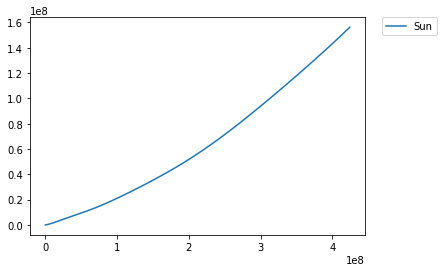

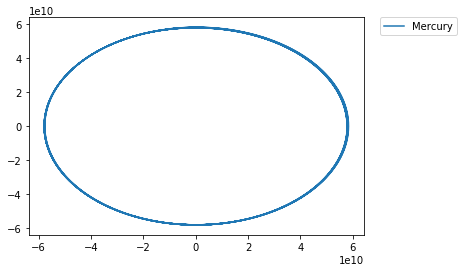

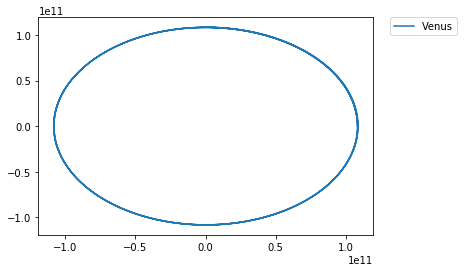

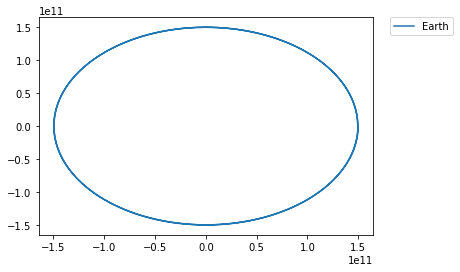

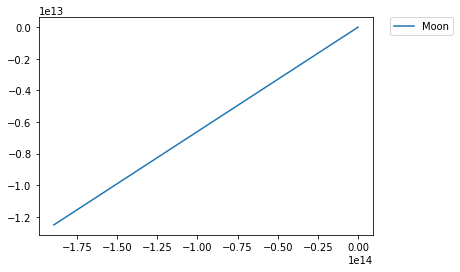

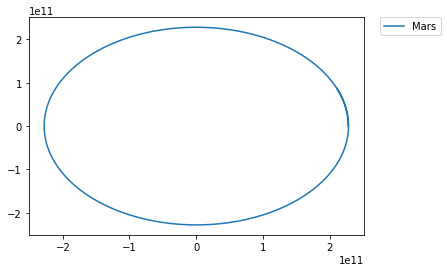

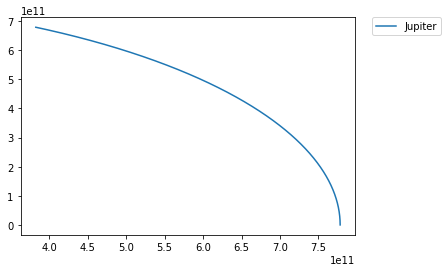

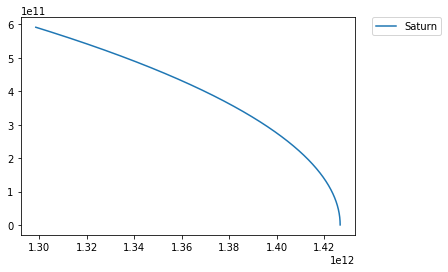

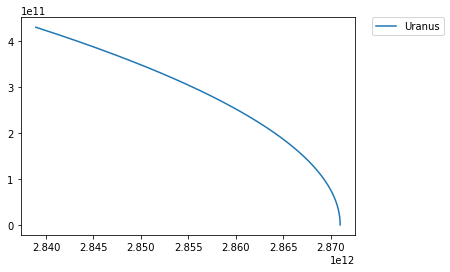

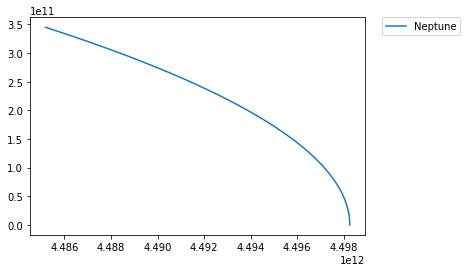

plot_list_length 1051200
[[  5.07429408e-04   1.01316701e-09   0.00000000e+00]
 [  5.79091749e+10   2.87232000e+06   0.00000000e+00]
 [  1.08208930e+11   2.10126000e+06   0.00000000e+00]
 [  1.49597890e+11   1.78716006e+06   0.00000000e+00]
 [  1.49597829e+11   3.84399995e+08   0.00000000e+00]
 [  2.27936640e+11   1.44786000e+06   0.00000000e+00]
 [  7.78412020e+11   7.84140000e+05   0.00000000e+00]
 [  1.42672540e+12   5.80320000e+05   0.00000000e+00]
 [  2.87097220e+12   4.10100000e+05   0.00000000e+00]
 [  4.49825290e+12   3.28620000e+05   0.00000000e+00]]
[[  2.02971763e-03   6.39414847e-09   0.00000000e+00]
 [  5.79091747e+10   5.74464000e+06   0.00000000e+00]
 [  1.08208930e+11   4.20252000e+06   0.00000000e+00]
 [  1.49597890e+11   3.57432024e+06   0.00000000e+00]
 [  1.49597767e+11   3.84399980e+08   0.00000000e+00]
 [  2.27936640e+11   2.89572000e+06   0.00000000e+00]
 [  7.78412020e+11   1.56828000e+06   0.00000000e+00]
 [  1.42672540e+12   1.16064000e+06   0.00000000e+00]
 [

In [41]:
plt.subplot(111)
plt.plot([x[0][0] for x in plot_list], [x[0][1] for x in plot_list], label="Sun")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[1][0] for x in plot_list], [x[1][1] for x in plot_list], label="Mercury")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[2][0] for x in plot_list], [x[2][1] for x in plot_list], label="Venus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[3][0] for x in plot_list], [x[3][1] for x in plot_list], label="Earth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[4][0] for x in plot_list], [x[4][1] for x in plot_list], label="Moon")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[5][0] for x in plot_list], [x[5][1] for x in plot_list], label="Mars")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[6][0] for x in plot_list], [x[6][1] for x in plot_list], label="Jupiter")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[7][0] for x in plot_list], [x[7][1] for x in plot_list], label="Saturn")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[8][0] for x in plot_list], [x[8][1] for x in plot_list], label="Uranus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[9][0] for x in plot_list], [x[9][1] for x in plot_list], label="Neptune")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print("plot_list_length", len(plot_list))
for _ in range (20):
    print(plot_list[_])

## Start as File

In [40]:
%%file ./cython_galaxy_extended/start.py
from loop import Loop
import matplotlib.pyplot as plt

#Sonnesystem

python_position = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [57_909_175_000, 0, 0], 
    #"Venus"
    [108_208_930_000, 0, 0],    
    #"Earth"
    [149_597_890_000, 0, 0],    
    #"Moon"
    [149_597_890_000, 384_400_000, 0],    
    #"Mars"
    [227_936_640_000, 0, 0],    
    #"Jupiter"
    [778_412_020_000, 0, 0],    
    #"Saturn"
    [1_426_725_400_000, 0, 0],    
    #"Uranus"
    [2_870_972_200_000, 0, 0],    
    #"Neptune"
    [4_498_252_900_000, 0, 0]
]

python_geschwindigkeit = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [0, 47_872, 0], 
    #"Venus"
    [0, 35_021, 0],    
    #"Earth"
    [0, 29_786, 0],    
    #"Moon"
    [-1_022, 0, 0],    
    #"Mars"
    [0, 24_131, 0],    
    #"Jupiter"
    [0, 13_069, 0],    
    #"Saturn"
    [0, 9_672, 0],    
    #"Uranus"
    [0, 6_835, 0],    
    #"Neptune"
    [0, 5_477, 0]
]

python_masse = [
    #"Sun"
    1.9889 * 10 ** 30,     
    #"Mercury"
    3.3022 * 10 ** 23, 
    #"Venus"
    4.8685 * 10 ** 24,    
    #"Earth"
    5.97219 * 10 ** 24,    
    #"Moon"
    7.34767309 * 10 ** 22,    
    #"Mars"
    6.4185 * 10 ** 23,    
    #"Jupiter"
    1.8987 * 10 ** 27,    
    #"Saturn"
    5.6851 * 10 ** 26,    
    #"Uranus"
    8.6849 * 10 ** 25,    
    #"Neptune"
    1.0244 * 10 ** 26
]

plot_list = []
iteration = 60 * 24 * 365 * 2
Loop(iteration, python_position, python_geschwindigkeit, python_masse, plot_list)

plt.subplot(111)
plt.plot([x[0][0] for x in plot_list], [x[0][1] for x in plot_list], label="Sun")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[1][0] for x in plot_list], [x[1][1] for x in plot_list], label="Mercury")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[2][0] for x in plot_list], [x[2][1] for x in plot_list], label="Venus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[3][0] for x in plot_list], [x[3][1] for x in plot_list], label="Earth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[4][0] for x in plot_list], [x[4][1] for x in plot_list], label="Moon")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[5][0] for x in plot_list], [x[5][1] for x in plot_list], label="Mars")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[6][0] for x in plot_list], [x[6][1] for x in plot_list], label="Jupiter")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[7][0] for x in plot_list], [x[7][1] for x in plot_list], label="Saturn")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[8][0] for x in plot_list], [x[8][1] for x in plot_list], label="Uranus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[9][0] for x in plot_list], [x[9][1] for x in plot_list], label="Neptune")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print("plot_list_length", len(plot_list))
for _ in range (40):
    print(plot_list[_])

Overwriting ./cython_galaxy_extended/start.py


In [ ]:
%%bash
cd cython_galaxy_extended
python3 start.py